# The Physical Layer as an Autoencoder


An autoencoder is a type of artificial neural network used to find a useful representation of some data $\mathbf{s}$ at an intermediate layer $\mathbf{x}$ through learning to reproduce the input at the output.

![autoencoder_0](https://github.com/mgoutay/autoencodeur/blob/master/Images/autoencoder_0.png?raw=true)



# Initialisation

**First : change the runtime and hardware acceleration**

Runtime $\rightarrow$ Change runtime type

- Runtime type : Python 3
- Hardware accelerator : GPU

In [1]:
# Install TensorFlow 2.0 on Google Collab if needed
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass

In [2]:
#Set the GPU you want to use
num_GPU = 0

import tensorflow as tf
print('Tensorflow version: ', tf.__version__)

gpus = tf.config.experimental.list_physical_devices("GPU")
print('Number of GPUs available :', len(gpus))

if num_GPU < len(gpus):
    tf.config.experimental.set_visible_devices(gpus[num_GPU], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[num_GPU], True)
    print('Only GPU number', num_GPU, 'used')

Tensorflow version:  2.0.0
Number of GPUs available : 4
Only GPU number 0 used


In [3]:
import os
import copy
import sys
import time
from datetime import datetime

import numpy as np
import matplotlib
import matplotlib.pyplot as plt  

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Dense, Softmax
from tensorflow.keras.regularizers import Regularizer

In [4]:
SEED = 1

# Communicating messages

**An autoencoder-based communication systems aims to implement the transmitter, channel, and receiver as a single NN which reconstructs its input at its output**

The goal is to learn a modulation wich will be robust with respect to the perturbations introduced by the channel.

The channel is implemented as a "Noise Layer" without any learnable parameters, wich must be differentiable in order to perform SGD on the transmitter's parameters.

Examples:

- AWGN channel : $y = x + n$

- ...

![autoencoder](https://github.com/mgoutay/autoencodeur/blob/master/Images/autoencoder.png?raw=true)

Let's transmit messages.

The first hyper-parameters to set are the total number of messages (or symbols) $M$ and the number of channel uses $N_c$

It can be seen that $M$ can also be seen as the modulation order. Indeed, sending one out of $M$ message is equivalent to sending $\log_2(M)$ bits.

We will implement the fowllowing network:

![autoencoder](https://github.com/mgoutay/ml_course/blob/master/Images/autoencoder.png?raw=true)

1. Each message $m$ is first converted to its one_hot representation. If we have the 3rd out of 8 message, the one_hot representation will be $[0, 0, 1, 0, 0, 0, 0, 0]$
2. That one_hot vector is then given to the first dense layer.
3. The last dense layer of the tranmsitter will output $2 N_c$ real numbers per symbol. 
4. They will be normalized to have an average energy of $1$ by the normalization layer. 
5. Then the $\mathbb{R}2\mathbb{C}$ layer will convert those $2N_c$ numbers onto $N_c$ complex numbers, that will be sent over the channel. Those are the transmitted symbols $x$.
6. The channel will add some random gaussian noise (AWGN channel)
7. The $\mathbb{C}2\mathbb{R}$ layer converts the $N_c$ complex numbers into $2N_c$ real numbers, that are given to the first dense layer. This is mandatory since Tensorflow does not have complex dense layers. The last dense layer has $M$ output (the number of different symbols).
8. The output of the last dense layer is given to the softmax layer. For a given received $y$, it outputs probabilities $\mathbf{p}_m = [p(m=0|y), p(m=1|y), ..., p(m=M|y)]$ that each symbols have been sent. Those probabilities are useful during training.


* Indeed, this is a typical classification task. We want to predict in which "class" (which symbol) the received signal $y$ belongs to. The usual loss for classification task is the categorical cross-entropy, which "compare" the true class ($m$) with the predicted probabilities $p_m$.


9. We take the symbol with the highest probability to have been sent with the $\text{argmax}$ layer. This is $\hat{m}$.



## Define the layers

In [63]:
class Normalization(Layer):

    def __init__(self, **kwargs):
        super(Normalization, self).__init__(**kwargs)

    def call(self, symbols):        
        # Normalize power per symbol to 1
        en_moy = tf.sqrt(2 * tf.reduce_mean(tf.square(symbols)))
        symbols_norm = tf.divide(symbols, en_moy)
        
        return symbols_norm

In [164]:
class R2C(Layer):

    def __init__(self, **kwargs):
        super(R2C, self).__init__(**kwargs)

    def call(self, x):
        # Converts 2Nc real numbers into Nc complex numbers
        ch_uses = int(tf.shape(x)[1]/2)
        x_cplx = tf.complex(x[:, :ch_uses], x[:, ch_uses:])
            
        return x_cplx

In [165]:
class C2R(Layer):

    def __init__(self, **kwargs):
        super(C2R, self).__init__(**kwargs)

    def call(self, y):
        #converts Nc complex numbers into 2Nc real numbers
        y_real = tf.concat([tf.math.real(y), tf.math.imag(y)], axis=1)
            
        return y_real

In [166]:
class OneHot(Layer):

    def __init__(self, M, **kwargs):
        super(OneHot, self).__init__(**kwargs)
        self.M = M

    def call(self, msg):
        
        one_hot_msg = tf.one_hot(msg, depth = M)
        
        return one_hot_msg

## Create the channel function

In [167]:
def channel(x, snr):
    # Adds random Gaussian noise to the input
    noise_stddev = tf.sqrt( 2 / tf.pow(10., snr/10.0))
    noise_r = tf.random.normal(shape = tf.shape(x), stddev = 1) * noise_stddev/tf.sqrt(2.)
    noise_i = tf.random.normal(shape = tf.shape(x), stddev = 1) * noise_stddev/tf.sqrt(2.)
    noise_cplx = tf.complex(noise_r, noise_i, name="noise")

    y = x + noise_cplx

    return y

## Generate messages

In [173]:
def generate_ds_msg(epoch_len, batch_size, M):
    
    #Generate a dataset of 'epoch_len' batches of messages.
    #Each batch have a size 'batch_size' and consists of messages (symbols) betwen 0 and M-1
    rand_msg = tf.random.uniform(shape=[epoch_len, batch_size], minval=0, maxval=M, dtype=tf.int32)
    features_ds = tf.data.Dataset.from_tensor_slices(rand_msg)
    
    #The labels are the same as the features : this is an autoencoder, we want to predict the same message that has been sent.
    labels_ds = features_ds
    
    return (features_ds, labels_ds)

## Define the model

In [168]:
class Autoencoder(Model):

    def __init__(self, M, ch_uses=1, **kwargs):
        super(Autoencoder, self).__init__(**kwargs)
        
        #Set the class' attributes
        self.M = M
        self.ch_uses = ch_uses
        
        #Define the transmitter NN as a keras model
        self.transmitter = tf.keras.models.Sequential([
            OneHot(self.M),
            Dense(self.M, activation='elu'),
            Dense(self.ch_uses*2, activation=None),
            Normalization(),
            R2C()
        ])
        
        #Define the receiver NN as a keras model
        self.receiver = tf.keras.models.Sequential([
            C2R(),
            Dense(2*self.ch_uses, activation='elu'),
            Dense(int((2*self.ch_uses+self.M)/2), activation='elu'),
            Dense(self.M, activation=None),
            Softmax()
        ])        

    
    def call(self, inputs, noise_stddev):
        
        # Forward pass : Inputs (messages) -> Transmitter -> Channel -> Receiver -> probas 
        self.x = self.transmitter(inputs)
        self.y = channel(self.x, noise_stddev)
        self.probas = self.receiver(self.y)
        
        return self.probas

## What about the loss function?

The loss function is the **sparse** (there is only one good class) **categorical cross-entropy**:

$$
\begin{align*}
L(\theta_T, \theta_R) &= \mathbb{E}_{m, y}[ - \log(\hat{p_{\theta_R}}(m | y)) ], y \thicksim p(y|x)\\
\end{align*}
$$

In [170]:
loss_func = tf.keras.losses.SparseCategoricalCrossentropy()

## Instantiate the autoencoder

In [171]:
# Number of messages
M = 8

# Number of channel uses
ch_uses = 1

In [172]:
#Set the seeds
np.random.seed(SEED)
tf.random.set_seed(SEED)

#Create the autoencoder
autoencoder = Autoencoder(M, ch_uses)

# See constellation before training

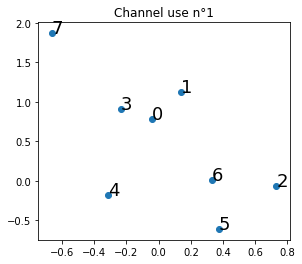

In [156]:
snr_eval = 10

# Form a batch containing every message
batch_msg = tf.cast(tf.linspace(0., M-1, M), tf.int32)

p_b = autoencoder(batch_msg, snr_eval)

msg_np = batch_msg.numpy()
x_np = autoencoder.x.numpy()

plt.figure(figsize=(ch_uses*4.5, 4))
for cu in range(ch_uses):
    plt.subplot(1, ch_uses, cu+1)
    plt.title('Channel use n°'+str(cu+1))
    plt.scatter(np.real(x_np[:, cu]), np.imag(x_np[:, cu]))
    for i in range(np.shape(x_np)[0]) :
        plt.text(np.real(x_np[i, cu]), np.imag(x_np[i, cu]), str(msg_np[i]), fontsize=18)

# Train

In [157]:
batch_size = 10000
epoch_size = 100
nb_epoch = 25
snr_training = 15/ch_uses

print('Symbol Error Rate after each epoch:')

#Initialize optimizer
optimizer = tf.keras.optimizers.Adam()

for epoch in range(nb_epoch):
    
    # Create a dataset for each epoch
    dataset = tf.data.Dataset.zip(generate_ds_msg(epoch_size, batch_size, M))

    # Iterate over the batches of the dataset.
    for step, (features, labels) in enumerate(dataset):
        # Open a GradientTape.
        with tf.GradientTape() as tape:

            # Forward pass.
            probas = autoencoder(features, snr_training)

            # Loss value for this batch.
            loss_value =  loss_func(y_true=labels, y_pred=probas)

        # Get gradients of loss wrt the weights.
        gradients = tape.gradient(loss_value, autoencoder.trainable_weights)

        # Update the weights of our linear layer.
        optimizer.apply_gradients(zip(gradients, autoencoder.trainable_weights))
    
    #Take the argmax of the probability distribution as the estimated message
    m_hat = tf.argmax(probas, axis=1, output_type=tf.int32)
    
    ser = tf.reduce_sum(tf.clip_by_value(tf.abs(labels-m_hat), 0, 1))/(batch_size)
    print(ser.numpy(), end=', ')
print('Done')

Symbol Error Rate after each epoch:
0.5644, 0.3924, 0.3358, 0.2583, 0.1032, 0.0644, 0.0454, 0.0335, 0.0305, 0.025, 0.0201, 0.0185, 0.0192, 0.013, 0.0124, 0.0151, 0.0136, 0.0144, 0.0094, 0.0118, 0.0121, 0.0131, 0.0127, 0.0126, 0.0116, Done


## Evaluate the model

In [158]:
snr_range = np.arange(-5, 21)
results=[]
bs_eval = 100000

for snr_eval in snr_range:
    
    batch_msg = tf.random.uniform(shape=[bs_eval], minval=0, maxval=M, dtype=tf.int32)
    
    p_m = autoencoder(batch_msg, snr_eval)
    m_hat = tf.argmax(p_m, axis=1, output_type=tf.int32)
    
    ser = tf.reduce_sum(tf.clip_by_value(tf.abs(batch_msg-m_hat), 0, 1))/(bs_eval)
    print(snr_eval, end=', ')
    results.append(ser.numpy())

-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 

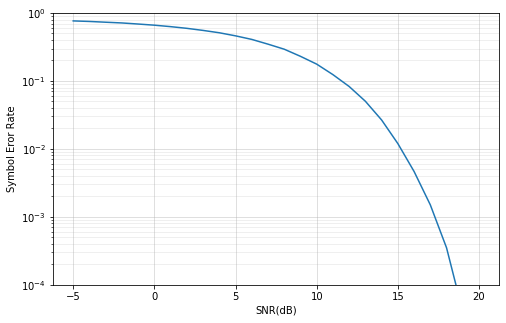

In [159]:
plt.figure(figsize=(8, 5))
plt.semilogy(snr_range, results)
plt.xlabel('SNR(dB)')
plt.ylabel('Symbol Eror Rate');
plt.ylim(1e-4, 1)
plt.grid(which='major', alpha=0.5)
plt.grid(which='minor', alpha=0.25)

## See learned constellation

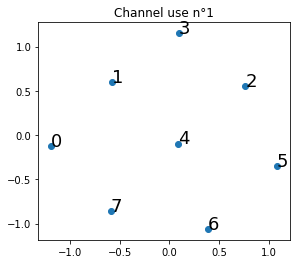

In [160]:
snr_eval = 10

# Form a batch containing every message
batch_msg = tf.cast(tf.linspace(0., M-1, M), tf.int32)

p_b = autoencoder(batch_msg, snr_eval)

msg_np = batch_msg.numpy()
x_np = autoencoder.x.numpy()

plt.figure(figsize=(ch_uses*4.5, 4))
for cu in range(ch_uses):
    plt.subplot(1, ch_uses, cu+1)
    plt.title('Channel use n°'+str(cu+1))
    plt.scatter(np.real(x_np[:, cu]), np.imag(x_np[:, cu]))
    for i in range(np.shape(x_np)[0]) :
        plt.text(np.real(x_np[i, cu]), np.imag(x_np[i, cu]), str(msg_np[i]), fontsize=18)